# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
from matplotlib.colors import LogNorm
from hep_VQAE import utils as ut

import warnings
warnings.filterwarnings('ignore')

In [25]:
data = np.load('../../data/electron-photon.npz', allow_pickle=True)

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

maxx = np.max(x_train)
minn = np.min(x_train)

x_train = x_train / maxx
x_test = x_test / maxx

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (100, 32, 32)
x_test:  (100, 32, 32)
y_train:  (100,)
y_test:  (100,)


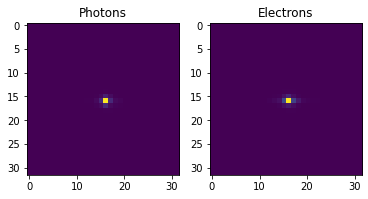

In [26]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

In [27]:
x_train = x_train.reshape(-1, x_train.shape[-1]*x_train.shape[-2])
x_test = x_test.reshape(-1, x_test.shape[-1]*x_test.shape[-2])

In [28]:
num_data, input_dim = x_train.shape

In [29]:
latent_dim = 16
ae = cae.Autoencoder1(input_dim, latent_dim)

In [30]:
ae.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.000001))

In [31]:
ae.build(x_train.shape)
ae.summary()

Model: "autoencoder1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 16)                106198    
                                                                 
 sequential_3 (Sequential)   (100, 1024)               107206    
                                                                 
Total params: 213,404
Trainable params: 213,404
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_train_e = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_e = x_test[y_test==1]
x_test = x_test[y_test==0]

In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist = ae.fit(x_train, x_train,
                epochs=5000,
                shuffle=True,
                batch_size=1,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/5000
44/44 [==============================] - 1s 14ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 8/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 10/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6928 - val_loss: 0.692

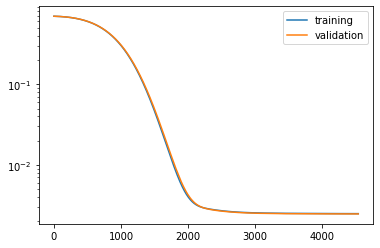

In [43]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [44]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=1)

def recon_acc(x):
    return 1 - mae(x)

def IF(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x*pred,axis=(1,2))
def IF2(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x**2,axis=(1,2))

In [45]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_e)

0.999946
0.99995923


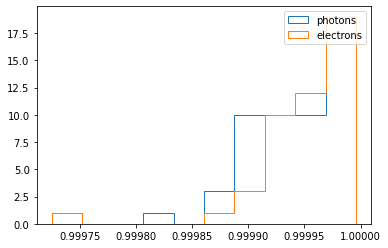

In [46]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=10)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

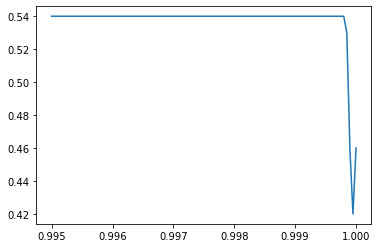

In [47]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 

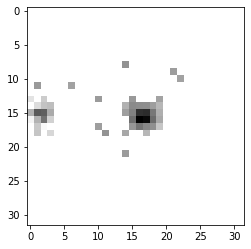

In [71]:
num = 50
testimg = ae.predict(x_test[num].reshape((1,x_test[0].shape[0]))).reshape((32,32))
plt.imshow(x_test[num].reshape((32,32)),cmap="binary",norm=LogNorm())

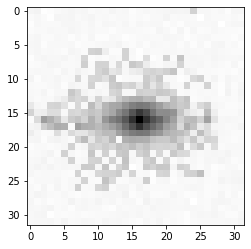

In [72]:
plt.imshow(testimg,cmap="binary",norm=LogNorm())

In [61]:
ut.test_collapse(x_test[:100], ae.predict(x_test[:100]))

0.2918004